In [1]:
import numpy as np
from os import listdir
from PIL import Image as PImage
import matplotlib.image as img
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score 
import random
%matplotlib inline

In [2]:
#!unzip att_faces.zip

#Function to load images from path and return labeled datasets

In [3]:
def loadImages(path):

    #list of folders for each person
    person_folder_list = listdir(path)
    #an empty numpy array to append the labeled instace for each person
    labeled_dataset = np.empty((1,10305))
    
    #access the folder for each person
    for person in person_folder_list: 
        imags_per_person_list = listdir(path+person)           #list of 10 images for each person
        for image in imags_per_person_list:
            image_matrix = img.imread(path + "/" + person + "/" + image)  #read each image as a matrix(112,92)
            label = [person]                                             #label is the folder name of each person
            image_vector = image_matrix.flatten()                        #convert the image matrix(112,92) to a vector(10304,1)
            labeled_vector = np.concatenate((label,image_vector))        #add label to each image vector(10305,1)
            labeled_vector = labeled_vector.reshape(1,10305)             #convert into row vector(1,10305)
            labeled_dataset = np.append(labeled_dataset,labeled_vector, axis=0)  #append labeled vector for each image as instance
    return labeled_dataset[1: , :]                                          #remove first row where it is a garabage value (np.empty)

In [4]:
path = "att_faces/orl_faces/"                                              #directory of data set

labeled_dataset = loadImages(path)                                         #the labeled dataset

#test-----------------------------
#labels = labeled_dataset[:,0]
#scaler = MinMaxScaler()
#scaler.fit(labeled_dataset[:,1:])
#labeled_dataset =  scaler.transform(labeled_dataset[:,1:])
#labeled_dataset = np.column_stack((labels,labeled_dataset))

#-------------------------------
print(labeled_dataset)

[['s1' '48' '49' ... '47' '46' '46']
 ['s1' '34' '34' ... '37' '40' '33']
 ['s1' '60' '60' ... '32' '34' '34']
 ...
 ['s9' '112' '109' ... '93' '88' '92']
 ['s9' '111' '114' ... '88' '86' '92']
 ['s9' '110' '112' ... '92' '87' '90']]


#splitting dataset into training set and test set

(200L, 10304L)
(200L, 10304L)
(200L,)
(200L,)
s1


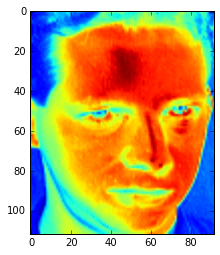

In [5]:
#split data sets into training set and test sets (odd rows for training set and even rows for test sets)
labeled_trainingSets = labeled_dataset[1::2]        #training set with labels(200,10305)
labeled_testSets = labeled_dataset[0::2]            #test set with labels(200,10305)

trainingSets = labeled_trainingSets[:,1:]           #training set without labels(200,10304)
trainingSets = trainingSets.astype(float)

testSets = labeled_testSets[:,1:]                   #test set without labels(200,10304)
testSets = testSets.astype(float)



print(trainingSets.shape)
print(testSets.shape)

label_trainingSet = labeled_trainingSets[:,0]      #labels of training set(200,1)
label_testSet = labeled_testSets[:,0]              #labels of testing set(200,1)
print(label_trainingSet.shape)
print(label_testSet.shape)

imgplot = plt.imshow(trainingSets[0,:].reshape(112,92))
print(label_trainingSet[0])

#PCA 

In [6]:

##PCA
##---------------------------------------------------------------------------------------------------
meanOfDataset = np.mean(trainingSets,axis = 0)              #Get the mean of each column
print(meanOfDataset.shape)
meanOfDataset = np.matrix(meanOfDataset)   #---->added
meanOfDatasetT = meanOfDataset.reshape(1,10304)           
print(meanOfDatasetT.shape)
onesMatrix = np.ones((200,1))                              #formation of (200,1) matrix of ones
meanOfDatasetMatrix = np.dot(onesMatrix,meanOfDatasetT)    #formation of(200,10304) matrix of mean
#print(meanOfDatasetMatrix.shape)


trainingSets_subtractedMean = trainingSets - meanOfDatasetMatrix   #training set with zero mean  ---->2nd operand meanOfDatasetT

covMatrix = np.cov(trainingSets_subtractedMean, rowvar=False)
print(covMatrix.shape)
print(np.sum(covMatrix))
eigenValues, eigenVectors = np.linalg.eigh(covMatrix)

#descending order
idx = np.argsort(eigenValues)[::-1]
eigenVectors = eigenVectors[:,idx]
 # sort eigenvectors according to same index
eigenValues = eigenValues[idx]

print(np.sum(eigenValues))


(10304L,)
(1L, 10304L)
(10304L, 10304L)
20440277164.01009
16073601.233919583


#Generate an array where each index corresponds to number of eigenVector and the value is the explained variance

In [7]:
def explained_variance_func(eigenValues_list):
  explained_variance_list = np.empty((10305,1))
  totalSum = np.sum(eigenValues_list)
  
  for i in range(10305):
    sum = np.sum(eigenValues_list[0:i])
    explained_variance = (sum*1.0)/totalSum
    explained_variance_list[i] = explained_variance
    
  return explained_variance_list
    

In [8]:
explained_variance = explained_variance_func(eigenValues)
print(explained_variance.shape)



(10305L, 1L)


# Function to determine number of eigenVectors based on alpha 

In [9]:
def number_of_eigenVectors_func(explained_variance, alpha):
  for i in range(10305):
    
    if(explained_variance[i] >= alpha):
      return i

In [10]:
number_of_eigenVectors_8 = number_of_eigenVectors_func(explained_variance, 0.8)
number_of_eigenVectors_85 = number_of_eigenVectors_func(explained_variance, 0.85)
number_of_eigenVectors_9 = number_of_eigenVectors_func(explained_variance, 0.9)
number_of_eigenVectors_95 = number_of_eigenVectors_func(explained_variance, 0.95)

print(number_of_eigenVectors_8)
print(number_of_eigenVectors_85)
print(number_of_eigenVectors_9)
print(number_of_eigenVectors_95)


36
52
76
117


#Reduced eigenVector matrix based on alpha value

In [11]:
eigenVector_8 = eigenVectors[:,0:number_of_eigenVectors_8]
eigenVector_85 = eigenVectors[:,0:number_of_eigenVectors_85]
eigenVector_9 = eigenVectors[:,0:number_of_eigenVectors_9]
eigenVector_95 = eigenVectors[:,0:number_of_eigenVectors_95]

#Projection of training set and testing sets using the same projection matrix

In [12]:
projected_trainingSet_8 = np.dot(trainingSets,eigenVector_8)
projected_trainingSet_85 = np.dot(trainingSets,eigenVector_85)
projected_trainingSet_9 = np.dot(trainingSets,eigenVector_9)
projected_trainingSet_95 = np.dot(trainingSets,eigenVector_95)


projected_testSet_8 = np.dot(testSets,eigenVector_8)
projected_testSet_85 = np.dot(testSets,eigenVector_85)
projected_testSet_9 = np.dot(testSets,eigenVector_9)
projected_testSet_95 = np.dot(testSets,eigenVector_95)
print(projected_testSet_8.shape)
print(projected_testSet_85.shape)
print(projected_testSet_9.shape)
print(projected_testSet_95.shape)


(200L, 36L)
(200L, 52L)
(200L, 76L)
(200L, 117L)


In [13]:
model = KNeighborsClassifier(n_neighbors=1)


#Prediction 

In [14]:
model.fit(projected_trainingSet_8,label_trainingSet)
pred_8 = model.predict(projected_testSet_8)
accuracy_8 = accuracy_score(label_testSet,pred_8)

model.fit(projected_trainingSet_85,label_trainingSet)
pred_85 = model.predict(projected_testSet_85)
accuracy_85 = accuracy_score(label_testSet,pred_85)

model.fit(projected_trainingSet_9,label_trainingSet)
pred_9 = model.predict(projected_testSet_9)
accuracy_9 = accuracy_score(label_testSet,pred_9)

model.fit(projected_trainingSet_95,label_trainingSet)
pred_95 = model.predict(projected_testSet_95)
accuracy_95 = accuracy_score(label_testSet,pred_95)


In [15]:
#accuracy_8 = accuracy_score(label_testSet,pred_8)
#accuracy_85 = accuracy_score(label_testSet,pred_85)
#accuracy_9 = accuracy_score(label_testSet,pred_9)
#accuracy_95 = accuracy_score(label_testSet,pred_95)

print(accuracy_8)
print(accuracy_85)
print(accuracy_9)
print(accuracy_95)

0.94
0.945
0.94
0.935


#Plotting relation between accuracy and alpha value

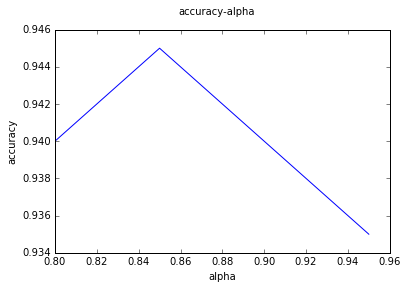

In [16]:
alpha_accuracy = np.array([[0.8,0.94],[0.85,0.945],[0.9,0.94],[0.95,0.935]])  
#plt.plot(alpha_accuracy[:,0],alpha_accuracy[:,1])

fig = plt.figure()
plt.plot(alpha_accuracy[:,0],alpha_accuracy[:,1])
fig.suptitle('accuracy-alpha')
plt.xlabel('alpha')
plt.ylabel('accuracy')

# Classifer tuning

In [17]:
model_3 = KNeighborsClassifier(n_neighbors=3)
model_5 = KNeighborsClassifier(n_neighbors=5)
model_7 = KNeighborsClassifier(n_neighbors=7)


model_3.fit(projected_trainingSet_85,label_trainingSet)
pred_3 = model_3.predict(projected_testSet_85)

model_5.fit(projected_trainingSet_85,label_trainingSet)
pred_5 = model_5.predict(projected_testSet_85)

model_7.fit(projected_trainingSet_85,label_trainingSet)
pred_7 = model_7.predict(projected_testSet_85)

# Prediction "Classifer tuning"

In [18]:
accuracy_3 = accuracy_score(label_testSet, pred_3)
accuracy_5 = accuracy_score(label_testSet, pred_5)
accuracy_7 = accuracy_score(label_testSet, pred_7)

print(accuracy_3)
print(accuracy_5)
print(accuracy_7)

0.86
0.795
0.785


# plotting the performance(accuracy) against k-value

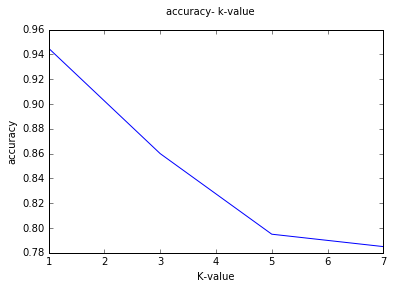

In [19]:
accuracy_kValue = np.array([[1,0.945],[3, 0.86],[5, 0.795],[7, 0.785]])
fig = plt.figure()
plt.plot(accuracy_kValue[:, 0], accuracy_kValue[:, 1])
fig.suptitle('accuracy- k-value')
plt.xlabel('K-value')
plt.ylabel('accuracy')

# Bounus
# a)changing the split percentage

In [20]:
dataSetDic = {label: labeled_dataset[labeled_dataset[:,0] == label][:,1:] for label in np.unique(labeled_dataset[:,0])}

y_test7_3 = np.empty((2,1))
y_train7_3= np.empty((2,1))
x_train7_3 = np.empty((1,10304))
x_test7_3 = np.empty((1,10304))

# Splitting the data 70% of each person data is for training set and the 30% for testing set

In [21]:
for i in range(41):
    
    if(i != 0):
        label = 's'+str(i)
        x_train7_3 = np.vstack((x_train7_3,dataSetDic[label][0:7,:]))
        x_test7_3 = np.vstack((x_test7_3,dataSetDic[label][7:,:]))
        
        for count in range(7):
            y_train7_3 = np.vstack((y_train7_3,[label]))
            
        for index in range(3):
            y_test7_3 = np.vstack((y_test7_3,[label]))

y_train7_3 = y_train7_3[2: , :]
x_train7_3 = x_train7_3[1: , :]
x_train7_3 = x_train7_3.astype(float)

y_test7_3 = y_test7_3[2: , :]
x_test7_3 = x_test7_3[1: , :]
x_test7_3 = x_test7_3.astype(float)

print(x_train7_3.shape)
print(x_test7_3.shape)


print(y_train7_3.shape)
print(y_test7_3.shape)

(280L, 10304L)
(120L, 10304L)
(280L, 1L)
(120L, 1L)


In [22]:
x_train_mean = np.mean(x_train7_3,axis = 0)              #Get the mean of each column
print(x_train_mean.shape)
x_train_mean = np.matrix(x_train_mean)   #---->added
x_train_meanT = x_train_mean.reshape(1,10304)           
print(x_train_meanT.shape)

#onesMatrix = np.ones((200,1))                              #formation of (200,1) matrix of ones
#meanOfDatasetMatrix = np.dot(onesMatrix,meanOfDatasetT)    #formation of(200,10304) matrix of mean
#print(meanOfDatasetMatrix.shape)


trainingSets_subtractedMean = x_train7_3 - x_train_meanT   #training set with zero mean  ---->2nd operand meanOfDatasetT

covMatrix2 = np.cov(trainingSets_subtractedMean, rowvar=False)
print(covMatrix2.shape)
print(np.sum(covMatrix2))
eigenValues2, eigenVectors2 = np.linalg.eigh(covMatrix2)

#descending order
idx = np.argsort(eigenValues2)[::-1]
eigenVectors2 = eigenVectors2[:,idx]
 # sort eigenvectors according to same index
eigenValues2 = eigenValues2[idx]

print(np.sum(eigenValues2))

(10304L,)
(1L, 10304L)
(10304L, 10304L)
20587540891.755836
16154319.008064501


In [116]:
explained_variance2 = explained_variance_func(eigenValues2)   #generate array where index coresponding to number of eigenvector 
print(explained_variance2.shape)                              #and explained_variance2[index] is value of explained variance

(10305L, 1L)


In [117]:
#get the number of eigenvectors corresponding to explained value

number_of_eigenVectors_8_b = number_of_eigenVectors_func(explained_variance2, 0.8)
number_of_eigenVectors_85_b = number_of_eigenVectors_func(explained_variance2, 0.85)
number_of_eigenVectors_9_b = number_of_eigenVectors_func(explained_variance2, 0.9)
number_of_eigenVectors_95_b = number_of_eigenVectors_func(explained_variance2, 0.95)

print(number_of_eigenVectors_8_b)
print(number_of_eigenVectors_85_b)
print(number_of_eigenVectors_9_b)
print(number_of_eigenVectors_95_b)

38
57
89
145


In [118]:
#generate a reduced eigenvector matrix based on explained variance

eigenVector_8_b = eigenVectors[:,0:number_of_eigenVectors_8_b]
eigenVector_85_b = eigenVectors[:,0:number_of_eigenVectors_85_b]
eigenVector_9_b = eigenVectors[:,0:number_of_eigenVectors_9_b]
eigenVector_95_b = eigenVectors[:,0:number_of_eigenVectors_95_b]

In [119]:
#projection of training set and testing set using same projection matrix

projected_x_train_8_b = np.dot(x_train7_3,eigenVector_8_b)
projected_x_train_85_b = np.dot(x_train7_3,eigenVector_85_b)
projected_x_train_9_b = np.dot(x_train7_3,eigenVector_9_b)
projected_x_train_95_b = np.dot(x_train7_3,eigenVector_95_b)
print(projected_x_train_95_b.shape)

projected_x_test_8_b = np.dot(x_test7_3,eigenVector_8_b)
projected_x_test_85_b = np.dot(x_test7_3,eigenVector_85_b)
projected_x_test_9_b = np.dot(x_test7_3,eigenVector_9_b)
projected_x_test_95_b = np.dot(x_test7_3,eigenVector_95_b)
print(projected_x_test_85_b.shape)



(280L, 145L)
(120L, 57L)


In [120]:
model_b = KNeighborsClassifier(n_neighbors=1)


In [126]:
model_b.fit(projected_x_train_8_b,y_train7_3)
pred_8_b = model_b.predict(projected_x_test_8_b)
accuracy_8_b = accuracy_score(y_test7_3,pred_8_b)

model_b.fit(projected_x_train_85_b,y_train7_3)
pred_85_b = model_b.predict(projected_x_test_85_b)
accuracy_85_b = accuracy_score(y_test7_3,pred_85_b)

model_b.fit(projected_x_train_9_b,y_train7_3)
pred_9_b = model_b.predict(projected_x_test_9_b)
accuracy_9_b = accuracy_score(y_test7_3,pred_9_b)

model_b.fit(projected_x_train_95_b,y_train7_3)
pred_95_b = model_b.predict(projected_x_test_95_b)
accuracy_95_b = accuracy_score(y_test7_3,pred_95_b)


D:\Downloads\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
D:\Downloads\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
D:\Downloads\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
D:\Downloads\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [125]:
print(accuracy_8_b)
print(accuracy_85_b)
print(accuracy_9_b)
print(accuracy_95_b)

0.9583333333333334
0.95
0.9583333333333334
0.95
